In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import imagej
ij = imagej.init('/home/s353960/rickdata/Programme/Fiji.app/') # Insert path to your Fiji app
from jnius import autoclass
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import imageio # dependencies: Numpy, Pillow
import cv2

from PIL import Image
from tifffile import imread
from tifffile import imwrite
from csbdeep.utils import plot_some
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches_reduced_target

Added 502 JARs to the Java classpath.


Using TensorFlow backend.


In [2]:
limit_gpu_memory(fraction=1/2)

In [3]:
# preprocess images
#------------------------------------------------------------------------------------------------------------------------
# groundtruth

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 2] #change channel number if channel for correlation of light microscopic image differs
        #0 = red; 1 = green; 2 = blue
    else: #stack
        channelofI = IM[0, :, :]
    return channelofI

Image.MAX_IMAGE_PIXELS = None #avoid error message for large images

GTdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/fluo_additional/'
Xdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/fluo_training/'
#os.mkdir(Xdirectory) # comment out if directory exists already

print('groundtruth--------------------------------------------------')
for filename in os.listdir(GTdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .png
        GTpath = os.path.join(GTdirectory, filename) # join path components intelligently
        IM = imageio.imread(GTpath)
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        GT = channelofI
        #GT = GT[:960, :] #uncomment if groundtruth image should be cropped [y, x]
        GT = cv2.resize(GT, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Xdirectory, name + '.tif')
        imwrite(writepath, GT)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, GT.shape)
        print(text)
        print(' ')



groundtruth--------------------------------------------------
s9_ds.png: processed
shape: (954, 1280) to  (256, 256)
 
s6_ds.png: processed
shape: (954, 1280) to  (256, 256)
 
s8_ds.png: processed
shape: (951, 1280) to  (256, 256)
 
s7_ds.png: processed
shape: (954, 1280) to  (256, 256)
 


In [4]:
# preprocess images
#------------------------------------------------------------------------------------------------------------------------
#input

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 2] #change channel number if channel for correlation of electron microscopic image differs
        #0 = red; 1 = green; 2 = blue
    else: #stack
        channelofI = IM [0, :, :]
    return channelofI

Image.MAX_IMAGE_PIXELS = None #avoid error message for large images

IPdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/sem_additional/'
Ydirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/sem_training/'
#os.mkdir(Ydirectory) # comment out if directory exists already
# stack or RGB

print('input--------------------------------------------------------')
for filename in os.listdir(IPdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .png
        print(filename)
        IPpath = os.path.join(IPdirectory, filename) # join path components intelligently  
        # equalize histogram with imageJ
        WindowManager = autoclass('ij.WindowManager')
        macro = """
        #@ String name
        open(name);
        run("Enhance Contrast...", "saturated=0.3 equalize");
        """
        args = {
        'name': IPpath
        }
        ij.py.run_macro(macro, args)
        IM = WindowManager.getCurrentImage()
        # ImagePlus object to numpy array
        IM = ij.py.from_java(IM)
        IM = IM.astype(np.uint8)
        #IM = IM[0,:]
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        #channelofI = channelofI[:960, :] #uncomment if input image should be cropped [y, x]
        channelofI = cv2.resize(channelofI, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        IP = np.stack((channelofI, channelofI), axis = 0)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Ydirectory, name + '.tif')
        imwrite(writepath, IP)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, IP.shape)
        print(text)
        print(' ')

input--------------------------------------------------------
s8_ds.png
s8_ds.png: processed
shape: (951, 1280) to  (2, 256, 256)
 
s7_ds.png
s7_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 
s9_ds.png
s9_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 
s6_ds.png
s6_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 


In [3]:
#create basepath, source_dirs and target_dir

Ydirectory = '/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/sem_training/'
Xdirectory = '/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/fluo_training/'

commonpath = os.path.commonpath([Ydirectory, Xdirectory])

def getdirectory(directory):
    if os.path.basename(directory) is '':
        path = os.path.dirname(directory)
        folder = os.path.basename(path)
    else:
        folder = os.path.basename(directory)
    return(folder)

directory = Ydirectory
Yfolder = getdirectory(directory)

directory = Xdirectory
Xfolder = getdirectory(directory)

In [4]:
raw_data = RawData.from_folder (
    basepath    = commonpath,
    source_dirs = [Yfolder],
    target_dir  = Xfolder,
    axes        = 'ZYX',
)

In [5]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,128,128),
    n_patches_per_image = 16,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = '/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/my_training_data.npz',
)

   40 raw images x    1 transformations   =    40 images
   40 images     x   16 patches per image =   640 patches in total
Input data:
/home/s353960/rickdata/F1 Praktikum/07_minimal_set_training: target='fluo_training', sources=['sem_training'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
2 x 128 x 128


100%|██████████| 40/40 [00:01<00:00, 21.71it/s]


Saving data to /home/s353960/rickdata/F1 Praktikum/07_minimal_set_training/my_training_data.npz.


In [6]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (640, 1, 2, 128, 128)
shape of Y   = (640, 1, 1, 128, 128)
axes  of X,Y = SCZYX


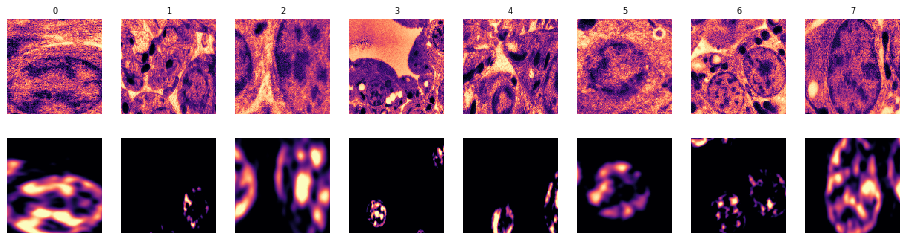

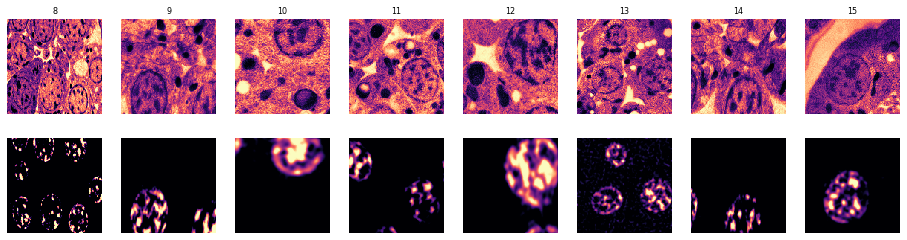

In [7]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;